# Matrix Structure Analysis

This notebook analyzes different matrix initialization methods and compares their structural properties:
1. Singular Value Distribution and Explained Variance
2. Eigenvalue Spectrum and Distribution
3. Degree Distribution Analysis

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import svd, eig
from scipy.stats import gaussian_kde
from connectome import load_sio_connectivity_data
from utils import get_weight_matrix

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [2]:
# Load the base connectivity matrix
data = load_sio_connectivity_data(
    connectivity_path='../data/signed_connectivity_matrix.csv',
    annotation_path='../data/science.add9330_data_s2.csv',
    rescale_factor=4e-2,
    normalization='minmax',
    sensory_type='visual'
)

# Get the base matrix
W_base = data['W']
print(f"Base matrix shape: {W_base.shape}")
print(f"Nonzero elements: {np.count_nonzero(W_base)}")
print(f"Sparsity: {np.count_nonzero(W_base) / (W_base.shape[0] * W_base.shape[1]) * 100:.2f}%")

Annotation file: Found 29 visual sensory neuron IDs
Annotation file: Found 400 output neuron IDs
Connectivity matrix contains 2952 neurons
After filtering, found 29 visual sensory neurons in matrix
After filtering, found 400 output neurons in matrix
Remaining 2523 neurons classified as internal
Base matrix shape: (2952, 2952)
Nonzero elements: 63545
Sparsity: 0.73%


In [4]:
W_base

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [41]:
# Generate different matrix variants
np.random.seed(42)  # For reproducibility

variants = {
    'Base': W_base,
    # 'Random': get_weight_matrix(W_base, 'random'),
    'Permuted': get_weight_matrix(W_base, 'permuted'),
    'Sparsity Matched': get_weight_matrix(W_base, 'sparsity_matched'),
    'Row Permuted': get_weight_matrix(W_base, 'row_permuted'),
    'Col Permuted': get_weight_matrix(W_base, 'col_permuted'),
    'Eigenvalue Matched': get_weight_matrix(W_base, 'eigenvalue_matched')
}

## 1. Singular Value Distribution Analysis

We analyze the singular value distribution and calculate the number of components needed to explain 99% of variance.

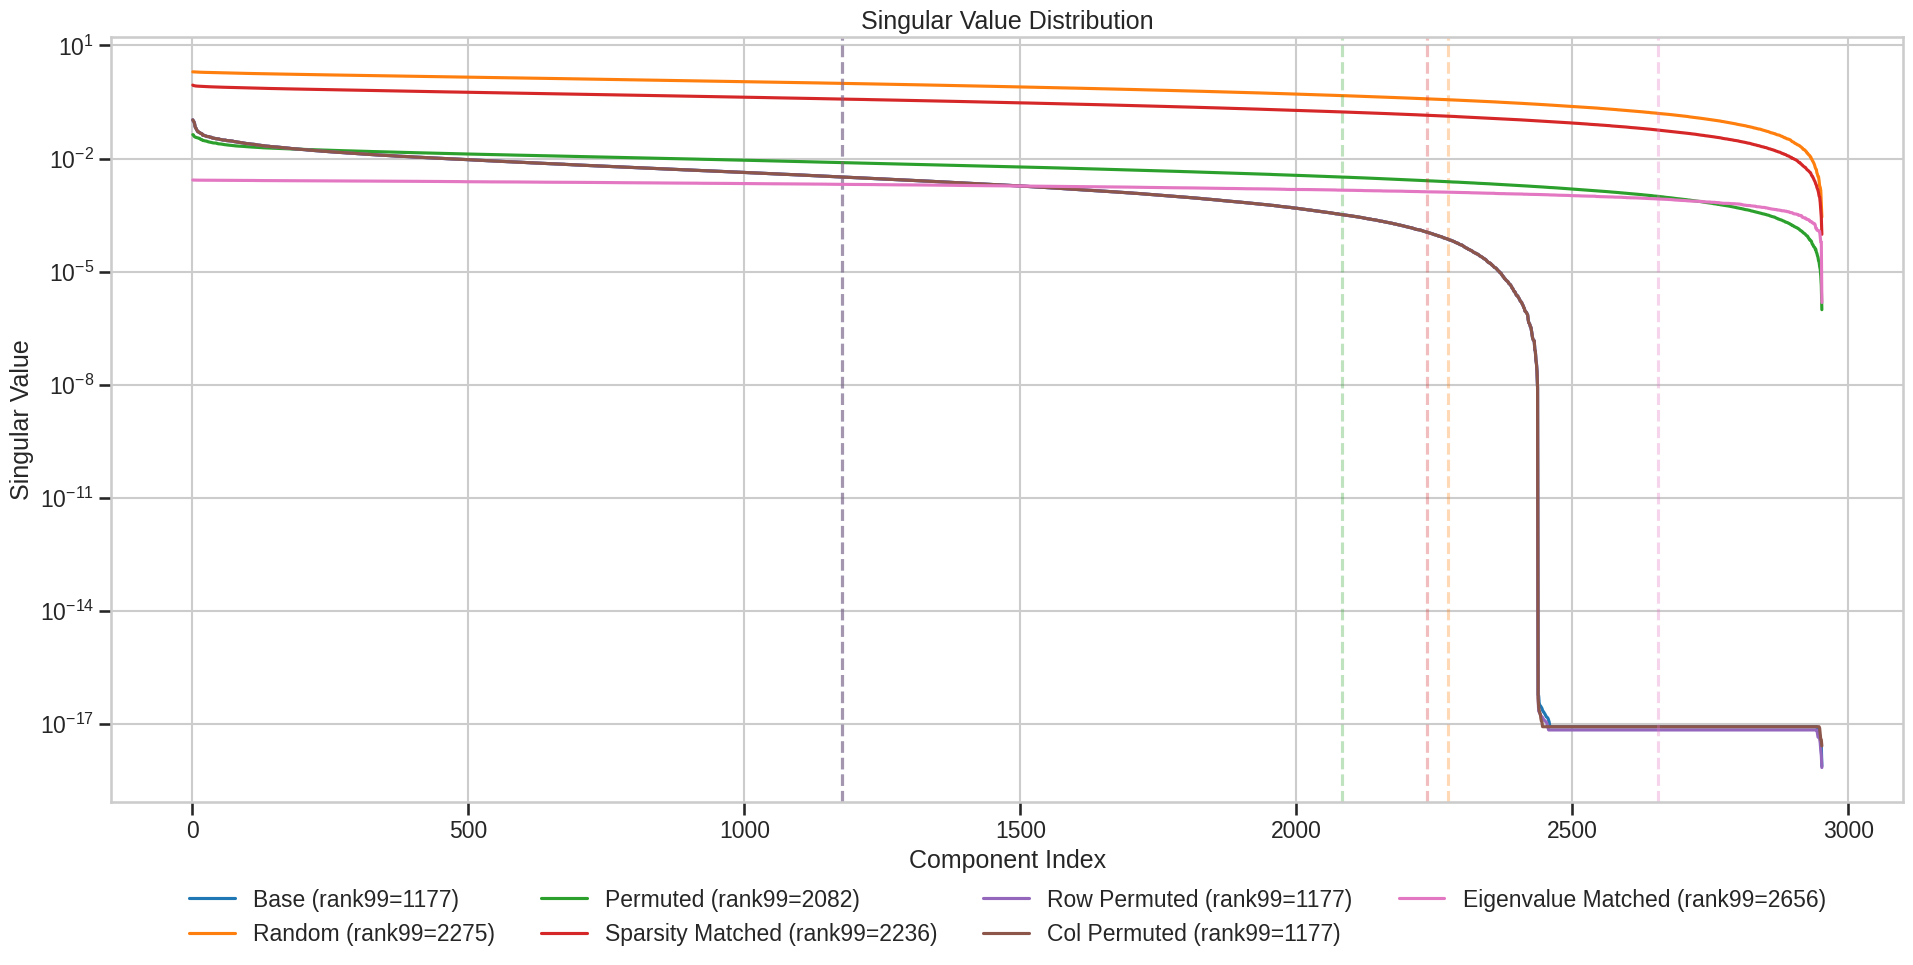

In [10]:
def analyze_singular_values(matrix):
    """Compute singular values and explained variance ratio"""
    U, s, Vt = svd(matrix)
    var_ratio = (s**2) / (s**2).sum()
    cum_var_ratio = np.cumsum(var_ratio)
    rank_99 = np.argmax(cum_var_ratio >= 0.99) + 1
    return s, cum_var_ratio, rank_99

plt.figure(figsize=(20, 10))
for name, matrix in variants.items():
    s, cum_var, rank_99 = analyze_singular_values(matrix)
    line, = plt.plot(range(1, len(s)+1), s, label=f"{name} (rank99={rank_99})")
    plt.axvline(x=rank_99, linestyle='--', alpha=0.3, color=line.get_color())

plt.xlabel('Component Index')
plt.ylabel('Singular Value')
plt.title('Singular Value Distribution')
plt.yscale('log')
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.tight_layout()
plt.show()

## 2. Eigenvalue Analysis

We analyze the eigenvalue spectrum and distribution of magnitudes.

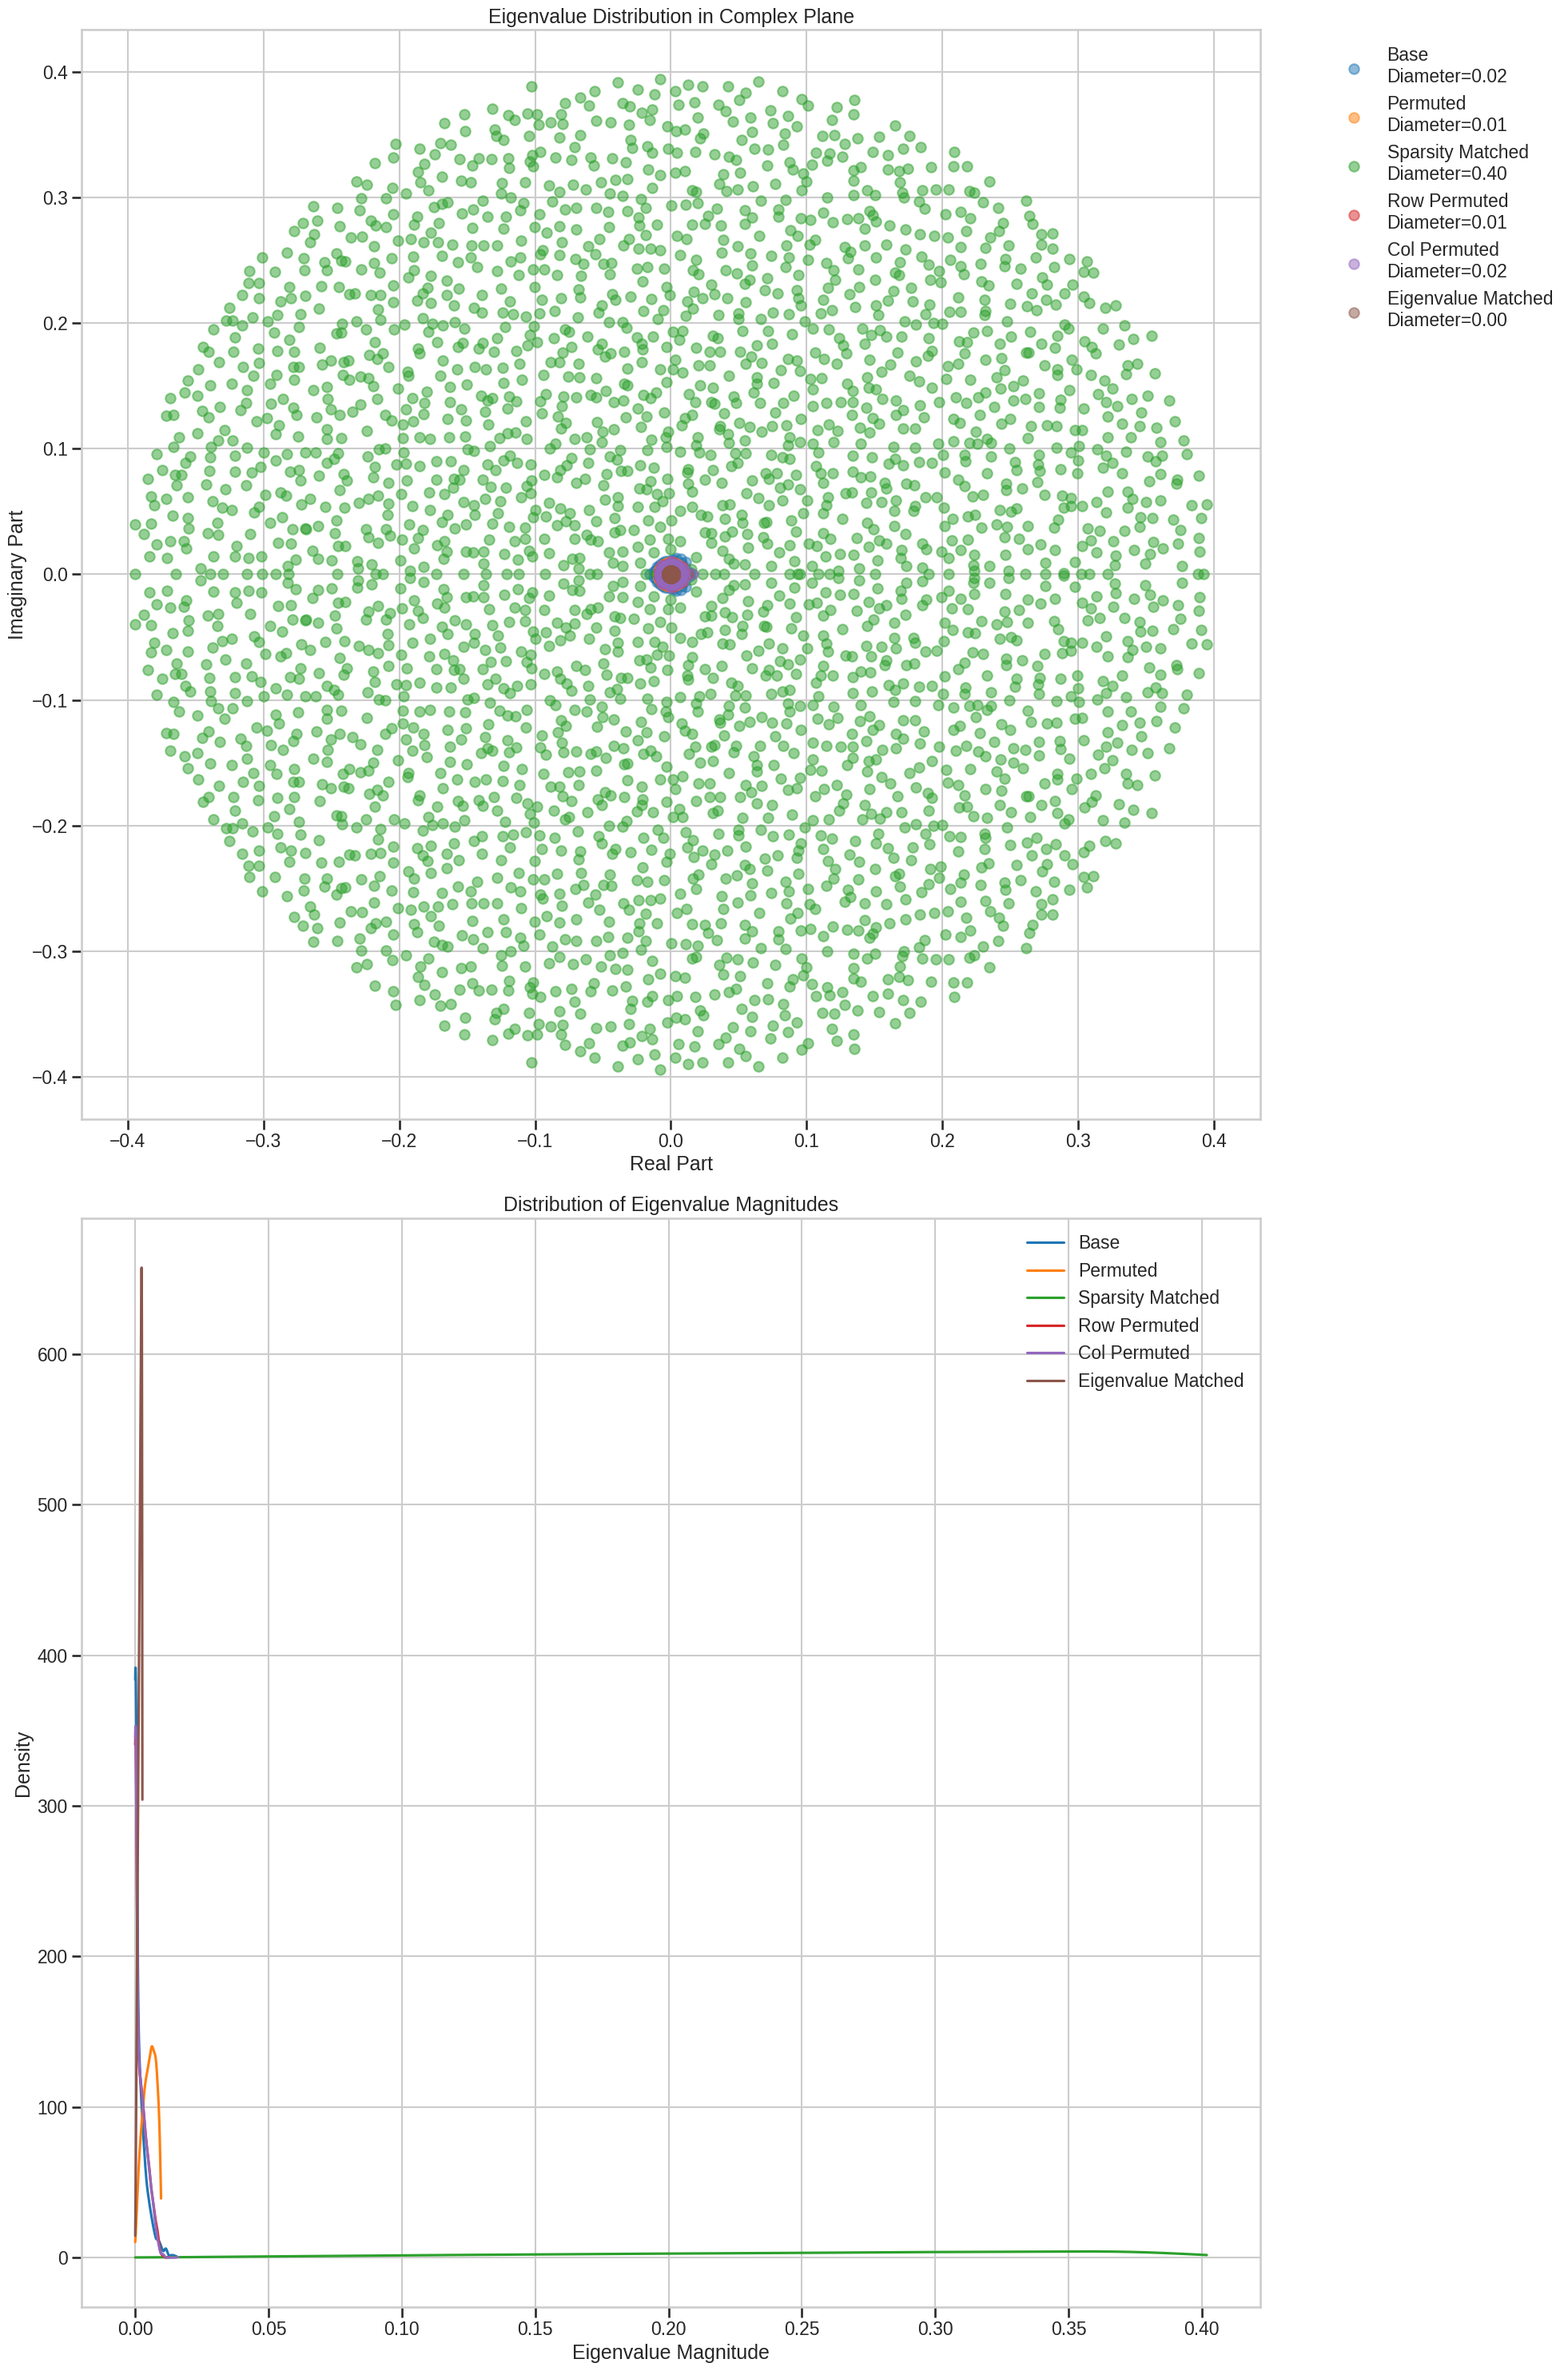

In [42]:
def analyze_eigenvalues(matrix):
    """Compute eigenvalues and spectrum diameter"""
    eigenvals = eig(matrix)[0]
    magnitudes = np.abs(eigenvals)
    diameter = np.max(magnitudes) - np.min(magnitudes)
    return eigenvals, diameter

# Plot eigenvalue distributions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 30))

# Complex plane plot
for name, matrix in variants.items():
    eigenvals, diameter = analyze_eigenvalues(matrix)
    ax1.scatter(eigenvals.real, eigenvals.imag, alpha=0.5, label=f"{name}\nDiameter={diameter:.2f}")

ax1.set_xlabel('Real Part')
ax1.set_ylabel('Imaginary Part')
ax1.set_title('Eigenvalue Distribution in Complex Plane')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True)

# Magnitude distribution
for name, matrix in variants.items():
    eigenvals, _ = analyze_eigenvalues(matrix)
    magnitudes = np.abs(eigenvals)
    density = gaussian_kde(magnitudes)
    xs = np.linspace(0, np.max(magnitudes), 200)
    ax2.plot(xs, density(xs), label=name)

ax2.set_xlabel('Eigenvalue Magnitude')
ax2.set_ylabel('Density')
ax2.set_title('Distribution of Eigenvalue Magnitudes')
ax2.legend()

plt.tight_layout()
plt.show()

## 3. Degree Distribution Analysis

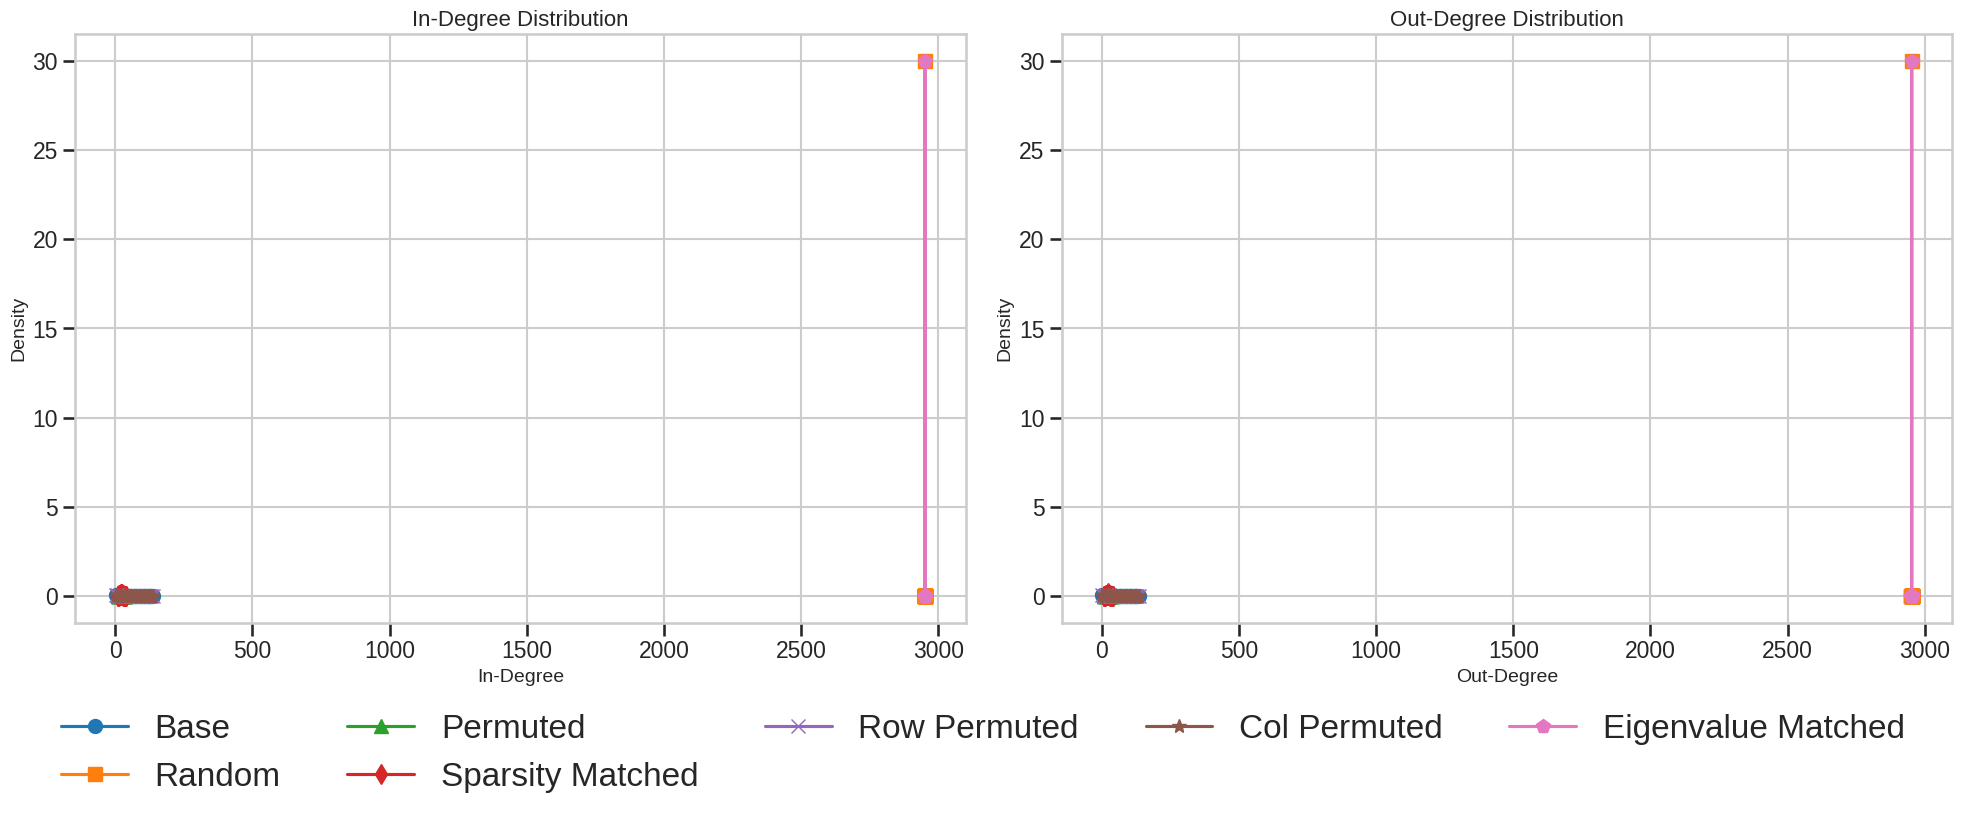

In [40]:
def analyze_degrees(matrix):
    """Compute in-degree and out-degree distributions"""
    in_degrees = np.sum(np.abs(matrix) > 0, axis=0)
    out_degrees = np.sum(np.abs(matrix) > 0, axis=1)
    return in_degrees, out_degrees

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Define markers to use for different variants
markers = ['o', 's', '^', 'd', 'x', '*', 'p', 'h']

# In-degree distribution
for i, (name, matrix) in enumerate(variants.items()):
    in_deg, _ = analyze_degrees(matrix)
    # Use histogram instead of gaussian_kde to avoid LinAlgError
    counts, bins = np.histogram(in_deg, bins=30, density=True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    marker = markers[i % len(markers)]
    ax1.plot(bin_centers, counts, label=name, marker=marker, markersize=10)

ax1.set_xlabel('In-Degree', fontsize=14)
ax1.set_ylabel('Density', fontsize=14)
ax1.set_title('In-Degree Distribution', fontsize=16)

# Out-degree distribution
for i, (name, matrix) in enumerate(variants.items()):
    _, out_deg = analyze_degrees(matrix)
    # Use histogram instead of gaussian_kde to avoid LinAlgError
    counts, bins = np.histogram(out_deg, bins=30, density=True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    marker = markers[i % len(markers)]
    ax2.plot(bin_centers, counts, label=name, marker=marker, markersize=10)

ax2.set_xlabel('Out-Degree', fontsize=14)
ax2.set_ylabel('Density', fontsize=14)
ax2.set_title('Out-Degree Distribution', fontsize=16)

# Create a single legend for both plots with 4 columns, centered at the bottom
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=5, fontsize=24)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Make room for the legend
plt.show()